In [21]:
# Mount your google drive
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [ ]:
# System setup Emma

# Change working directory to project folder
#os.chdir('/Users/emmamorlock/git/GitHub/Earth-System-Modelling')

# Append project to path for easy imports
#sys.path.append('/Users/emmamorlock/git/GitHub/Earth-System-Modelling')

In [2]:
# System setup Lars

# Change working directory to project folder
os.chdir('C:/Users/morge/Documents/GitHub/Earth-System-Modelling')

# Append project to path for easy imports
sys.path.append('C:/Users/morge/Documents/GitHub/Earth-System-Modelling')

In [3]:
# Import the model
# The model is stored in another file
# all functions are definded there...
from swbm_mini_ice import prepro, predict_ts, model_correlation

# Now you have access to the functions:
# prepro() predict_ts() model_correlation()

# Read the data https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Germany_new.csv

data_DE = pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Germany_new.csv")
data_SWE = pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Sweden_new.csv")
data_ES = pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Spain_new.csv")

# Prepare the data
data_prepro_DE = prepro(data_DE)
data_prepro_SWE = prepro(data_SWE)
data_prepro_ES = prepro(data_ES)

In [4]:
# Define initial parameters
config = {
    'c_s': 420,    # soil water holding capacity in mm, cs = 210mm, 420mm, 840mm
    'a': 4,        # runoff function shape α, α = 2,4,8
    'g': 0.5,      # ET function shape γ, γ = 0.2, 0.5, 0.8
    'b0': 0.8,     # maximum of ET function β, β = 0.4, 0.6, 0.8
    'i_max': 20,    # max infiltrationsrate zwischen 20 mm/day und unendlich
    't_ice': -3     # temp for freezing soil
}


In [5]:
# Run the SWBM model
data_prepro = data_prepro_DE
moisture, runoff, et_flux, runoff_s, runoff_h, runoff_ice = predict_ts(data_prepro, config)

5852.336146157869
616.8567269999996
151.07163407027025


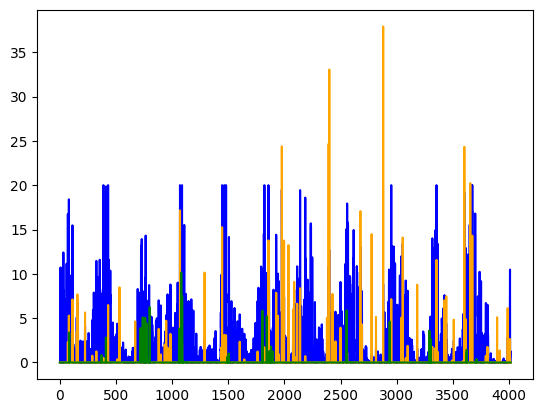

In [6]:
print(sum(runoff_s))
print(sum(runoff_h))
print(sum(runoff_ice))

plt.plot(runoff_s, color='blue')
plt.plot(runoff_h, color='orange')
plt.plot(runoff_ice, color='green')

plt.show()

6620.26450722814
6620.26450722814


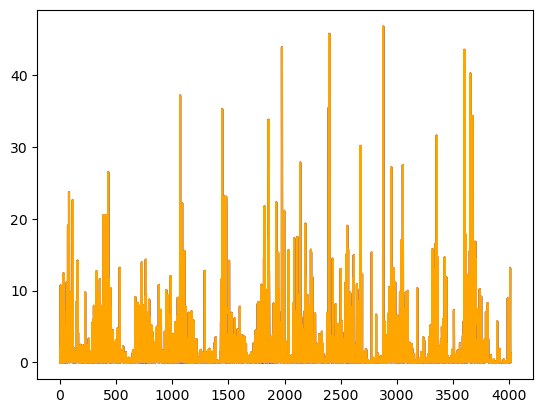

In [6]:
print(sum(runoff_h + runoff_s + runoff_ice))
print(sum(runoff))
plt.plot(runoff_h + runoff_s, color='blue')
plt.plot(runoff, color='orange')
plt.show()

In [7]:
# Compute correlation over the whole timeseries
corrs = model_correlation(data_prepro, (moisture, runoff, et_flux))
print("Correlation between observed data and model outputs:\n")
print(f"Soil Moisture (sm):      {corrs['sm']:.3f}")
print(f"Runoff (ro):             {corrs['ro']:.3f}")
print(f"Evapotranspiration (et): {corrs['et']:.3f}")
print(f"\nSum of correlations:   {corrs['sum']:.3f}")

Correlation between observed data and model outputs:

Soil Moisture (sm):      0.872
Runoff (ro):             0.701
Evapotranspiration (et): 0.879

Sum of correlations:   2.453


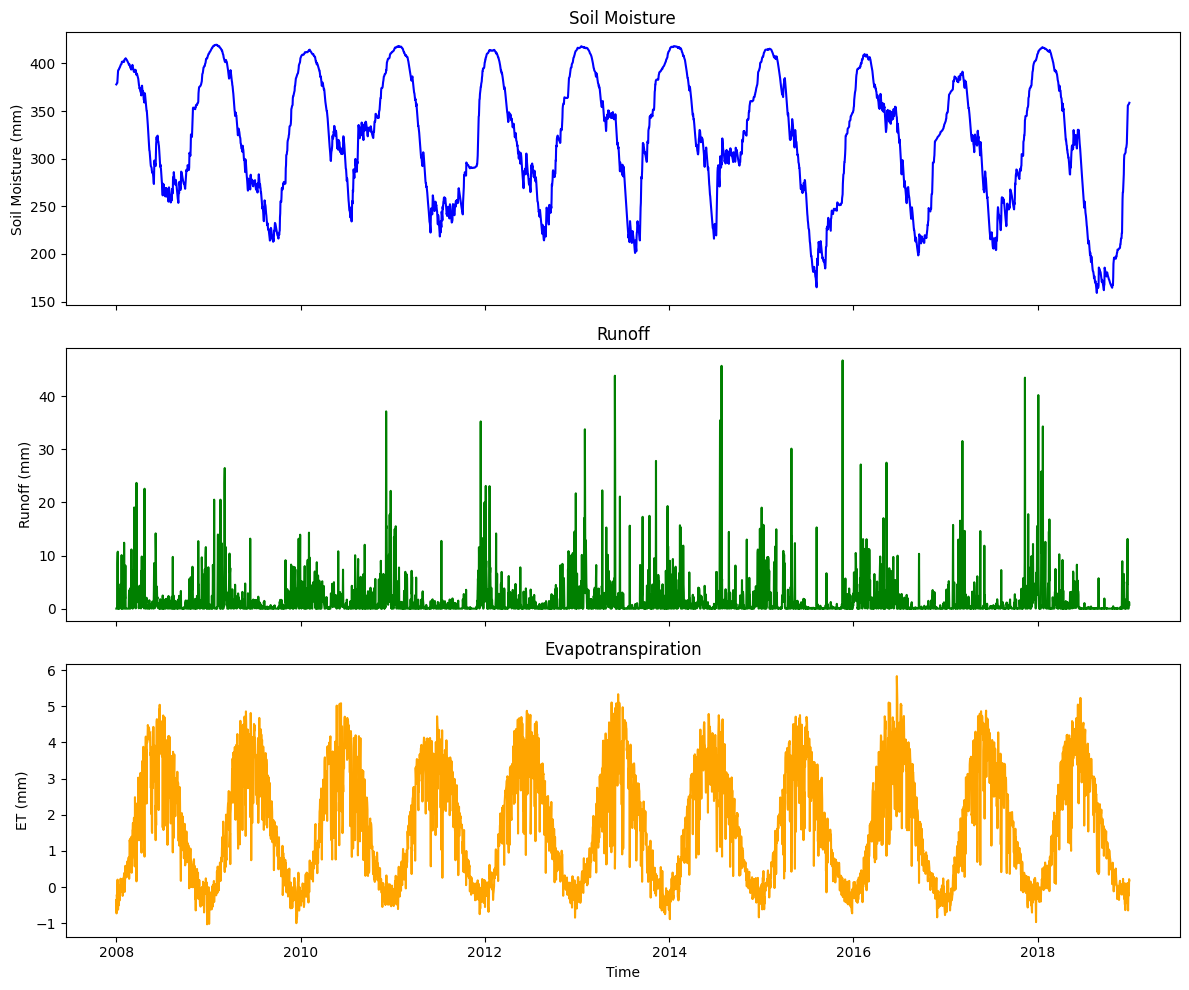

In [18]:
# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Soil moisture
axes[0].plot(data_prepro['time'], moisture, color='blue')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture')

# Runoff
axes[1].plot(data_prepro['time'], runoff, color='green')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff')

# Evapotranspiration
axes[2].plot(data_prepro['time'], et_flux, color='orange')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration')
axes[2].set_xlabel('Time')

plt.tight_layout()
plt.show()

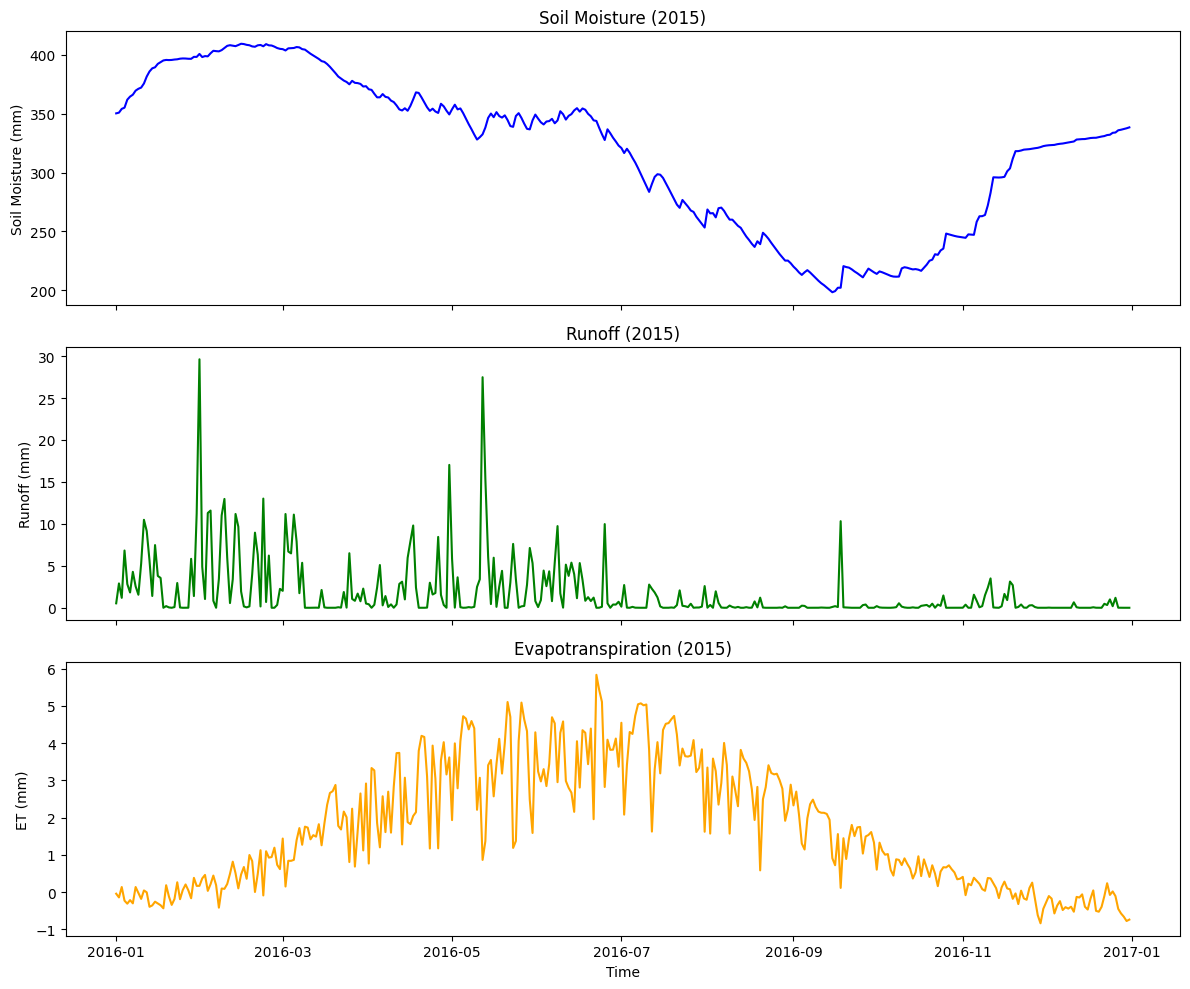

In [ ]:
# Plot only one year
one_year = data_prepro[(data_prepro['time'] >= "2016-01-01") & (data_prepro['time'] <= "2016-12-31")]
moisture_year = moisture[one_year.index]
runoff_year = runoff[one_year.index]
et_flux_year = et_flux[one_year.index]
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
# Soil moisture
axes[0].plot(one_year['time'], moisture_year, color='blue')
axes[0].set_ylabel('Soil Moisture (mm)')
axes[0].set_title('Soil Moisture (2015)')
# Runoff
axes[1].plot(one_year['time'], runoff_year, color='green')
axes[1].set_ylabel('Runoff (mm)')
axes[1].set_title('Runoff (2015)')
# Evapotranspiration
axes[2].plot(one_year['time'], et_flux_year, color='orange')
axes[2].set_ylabel('ET (mm)')
axes[2].set_title('Evapotranspiration (2015)')
axes[2].set_xlabel('Time')
plt.tight_layout()
plt.show()

### Kalibrieren und iterieren

In [7]:
import pandas as pd
from swbm_mini_ice import prepro, predict_ts, model_correlation

# Daten laden
data_all = {
    'Germany': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Germany_new.csv"),
    'Spain': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Spain_new.csv"),
    'Sweden': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Sweden_new.csv"),
}

# Zeitfilter
def filter_2008_2013(df):
    df['time'] = pd.to_datetime(df['time'])
    return df[(df['time'].dt.year >= 2008) & (df['time'].dt.year <= 2013)]

# Parameter
cs_vals = [210, 420, 840]
a_vals = [2, 4, 8]
g_vals = [0.2, 0.5, 0.8]
b0_vals = [0.4, 0.6, 0.8]
i_max_vals = [20, 40, 200]
t_ice_vals = [-3, 0, 3]

# Liste für Ergebnisse erstellen
results = []

# Iterieren
for site, df in data_all.items():
    df_filtered = filter_2008_2013(df)
    df_prepro = prepro(df_filtered)

    for cs in cs_vals:
        for a in a_vals:
            for g in g_vals:
                for b0 in b0_vals:
                    for i_max in i_max_vals:
                        for t_ice in t_ice_vals:
                        
                            config = {
                                'c_s': cs,
                                'a': a,
                                'g': g,
                                'b0': b0,
                                'i_max': i_max,
                                't_ice': t_ice
                            }

                            # Modell ausführen
                            sm_model, ro_model, et_model, ro_s, ro_h, ro_ice = predict_ts(df_prepro, config)
    
                            # Neue DataFrame-Kopie zur Korrelation
                            df_run = df_prepro.copy()
                            df_run['sm_model'] = sm_model
                            df_run['ro_model'] = ro_model
                            df_run['et_model'] = et_model
    
                            # Korrelation berechnen
    
                            corrs = model_correlation(
                                df_prepro,
                                (sm_model, ro_model, et_model)
                            )
    
                            # Ergebnisse speichern
                            results.append({
                                'site': site,
                                'c_s': cs,
                                'a': a,
                                'g': g,
                                'b0': b0,
                                'i_max': i_max,
                                't_ice': t_ice,
                                **corrs  # z. B. sm_corr, ro_corr, et_corr
                            })

# Ergebnisse speichern
#df_results = pd.DataFrame(results)
#df_results.to_csv("model_results_2008_2013.csv", index=False)


KeyboardInterrupt: 

In [10]:
# Ergebnisse speichern
df_results = pd.DataFrame(results)
df_results.to_csv("model_results_2008_2013.csv", index=False)

In [11]:
model_results = pd.read_csv("model_results_2008_2013.csv")
model_results.head()

,site,c_s,a,g,b0,i_max,t_ice,sm,ro,et,sum
0,Germany,210,2,0.2,0.4,20,-3,0.872719,0.608446,0.896243,2.377408
1,Germany,210,2,0.2,0.4,20,0,0.872769,0.607006,0.896293,2.376067
2,Germany,210,2,0.2,0.4,20,3,0.872271,0.601619,0.896495,2.370385
3,Germany,210,2,0.2,0.4,40,-3,0.875677,0.592569,0.896731,2.364977
4,Germany,210,2,0.2,0.4,40,0,0.875149,0.591345,0.896771,2.363264


In [12]:
model_results.tail()

,site,c_s,a,g,b0,i_max,t_ice,sm,ro,et,sum
2182,Sweden,840,8,0.8,0.8,40,0,-0.239056,0.041833,0.865347,0.668124
2183,Sweden,840,8,0.8,0.8,40,3,-0.220868,0.047477,0.865710,0.692320
2184,Sweden,840,8,0.8,0.8,200,-3,-0.275160,0.052393,0.864909,0.642142
2185,Sweden,840,8,0.8,0.8,200,0,-0.239056,0.041773,0.865348,0.668066
2186,Sweden,840,8,0.8,0.8,200,3,-0.220867,0.047421,0.865711,0.692266


In [13]:
top3country = (
    model_results
    .sort_values(by='sum', ascending=False)
    .groupby('site')
    .head(3)
)

print(top3country)

         site  c_s  a    g   b0  i_max  t_ice        sm        ro        et  \
414   Germany  420  8  0.2  0.6     20     -3  0.887695  0.623792  0.898812   
415   Germany  420  8  0.2  0.6     20      0  0.886321  0.622705  0.898844   
90    Germany  210  4  0.2  0.6     20     -3  0.888669  0.620823  0.894878   
873     Spain  210  4  0.8  0.6     20     -3  0.907323  0.629796  0.854921   
874     Spain  210  4  0.8  0.6     20      0  0.907277  0.628717  0.854951   
882     Spain  210  4  0.8  0.8     20     -3  0.917575  0.632413  0.834509   
1635   Sweden  210  8  0.2  0.6    200     -3 -0.111968  0.078058  0.875393   
1632   Sweden  210  8  0.2  0.6     40     -3 -0.112007  0.078088  0.875393   
1636   Sweden  210  8  0.2  0.6    200      0 -0.113610  0.074250  0.875381   

           sum  
414   2.410299  
415   2.407870  
90    2.404370  
873   2.392040  
874   2.390944  
882   2.384497  
1635  0.841483  
1632  0.841474  
1636  0.836021  


### Model: 3 best parameters 2014 - 2018

In [14]:
top3 = (
    model_results
    .sort_values(by='sum', ascending=False)
    .groupby('site')
    .head(1)
)

print(top3)

top3.to_csv("top3_results_2008_2013.csv", index=False)


         site  c_s  a    g   b0  i_max  t_ice        sm        ro        et  \
414   Germany  420  8  0.2  0.6     20     -3  0.887695  0.623792  0.898812   
873     Spain  210  4  0.8  0.6     20     -3  0.907323  0.629796  0.854921   
1635   Sweden  210  8  0.2  0.6    200     -3 -0.111968  0.078058  0.875393   

           sum  
414   2.410299  
873   2.392040  
1635  0.841483  


In [18]:

# Daten laden
data_all = {
    'Germany': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Germany_new.csv"),
    'Spain': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Spain_new.csv"),
    'Sweden': pd.read_csv("https://raw.githubusercontent.com/emorl/Earth-System-Modelling/main/data/Data_swbm_Sweden_new.csv"),
}

# Zeitfilter 2014–2018
def filter_2014_2018(df):
    df['time'] = pd.to_datetime(df['time'])
    return df[(df['time'].dt.year >= 2014) & (df['time'].dt.year <= 2018)]
df_filtered = filter_2014_2018(df).reset_index(drop=True)

# Beste Parameter pro Land
best_params = {
    'Germany': {'c_s':420, 'a':8, 'g':0.2, 'b0':0.6, 'i_max':20, 't_ice':-3},
    'Spain':   {'c_s':210, 'a':4, 'g':0.8, 'b0':0.6, 'i_max':20, 't_ice':-3},
    'Sweden':  {'c_s':210, 'a':8, 'g':0.2, 'b0':0.6, 'i_max':200,'t_ice':-3}
}

results = []

# Iteration über Länder
for site, df in data_all.items():

    df_filtered = df_filtered
    df_prepro = prepro(df_filtered)

    config = best_params[site]

    # Modell laufen lassen
    sm_model, ro_model, et_model, ro_s, ro_h, ro_ice = predict_ts(df_prepro, config)

    # Korrelation berechnen
    corrs = model_correlation(
        df_prepro,
        (sm_model, ro_model, et_model)
    )

    results.append({
        'site': site,
        **config,
        **corrs
    })

# Ergebnisse speichern
df_results_2014_2018 = pd.DataFrame(results)
df_results_2014_2018.to_csv("model_results_2014_2018.csv", index=False)

print(df_results_2014_2018)


      site  c_s  a    g   b0  i_max  t_ice        sm        ro        et  \
0  Germany  420  8  0.2  0.6     20     -3  0.891697  0.745805  0.900593   
1    Spain  210  4  0.8  0.6     20     -3  0.880898  0.724794  0.867551   
2   Sweden  210  8  0.2  0.6    200     -3  0.878465  0.698137  0.897620   

        sum  
0  2.538094  
1  2.473242  
2  2.474222  


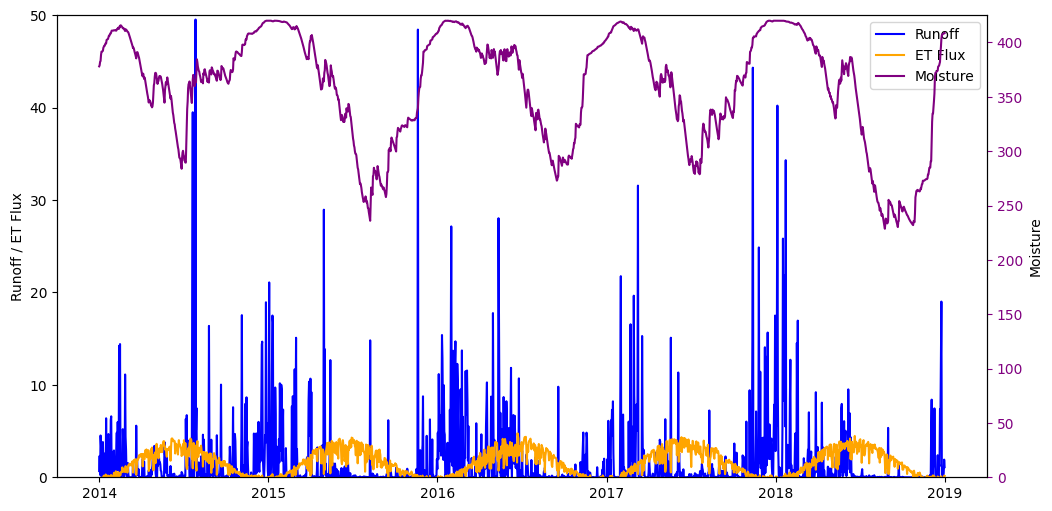

In [27]:
# Deutschland
def filter_2014_2018(df):
    df_copy = df.copy()  # avoid changing original df
    df_copy['time'] = pd.to_datetime(df_copy['time'])
    return df_copy[(df_copy['time'].dt.year >= 2014) & (df_copy['time'].dt.year <= 2018)]

data_prepro = filter_2014_2018(data_prepro_DE).reset_index(drop=True)

# Define initial parameters
config_DE = {
    'c_s': 420,    # soil water holding capacity in mm, cs = 210mm, 420mm, 840mm
    'a': 8,        # runoff function shape α, α = 2,4,8
    'g': 0.2,      # ET function shape γ, γ = 0.2, 0.5, 0.8
    'b0': 0.6,     # maximum of ET function β, β = 0.4, 0.6, 0.8
    'i_max': 20,    # max infiltrationsrate zwischen 20 mm/day und unendlich
    't_ice': -3     # temp for freezing soil
}

moisture, runoff, et_flux, runoff_s, runoff_h, runoff_ice = predict_ts(data_prepro, config_DE)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: runoff and et_flux
ax1.plot(data_prepro['time'], runoff, color='blue', label='Runoff')
ax1.plot(data_prepro['time'], et_flux, color='orange', label='ET Flux')
ax1.set_ylabel('Runoff / ET Flux')
ax1.tick_params(axis='y')
ax1.set_ylim(0, 50)  

# Right y-axis: moisture
ax2 = ax1.twinx()
ax2.plot(data_prepro['time'], moisture, color='purple', label='Moisture')
ax2.set_ylabel('Moisture')
ax2.tick_params(axis='y', colors='purple')
ax2.set_ylim(0, 425)  

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.show()

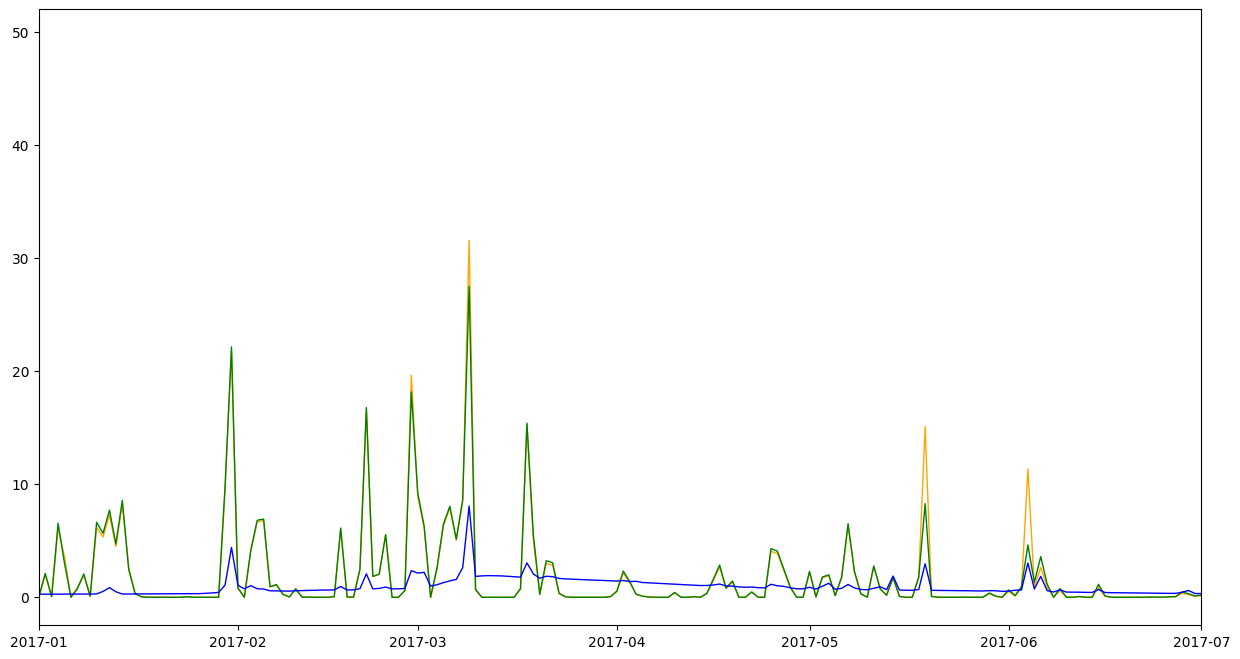

In [51]:
# Deutschland
from swbm_mini_ice import prepro, predict_ts, model_correlation
from swbm_mini import predict_ts as predict_old

def filter_2014_2018(df):
    df_copy = df.copy()  # avoid changing original df
    df_copy['time'] = pd.to_datetime(df_copy['time'])
    return df_copy[(df_copy['time'].dt.year >= 2014) & (df_copy['time'].dt.year <= 2018)]

data_prepro = filter_2014_2018(data_prepro_DE).reset_index(drop=True)

# Define initial parameters
config_DE = {
    'c_s': 420,    # soil water holding capacity in mm, cs = 210mm, 420mm, 840mm
    'a': 8,        # runoff function shape α, α = 2,4,8
    'g': 0.2,      # ET function shape γ, γ = 0.2, 0.5, 0.8
    'b0': 0.6,     # maximum of ET function β, β = 0.4, 0.6, 0.8
    'i_max': 20,    # max infiltrationsrate zwischen 20 mm/day und unendlich
    't_ice': -3     # temp for freezing soil
}

moisture, runoff, et_flux, runoff_s, runoff_h, runoff_ice = predict_ts(data_prepro, config_DE)

moisture_old, runoff_old, et_flux_old, = predict_old(data_prepro, config_DE)


# Create a wider figure
plt.figure(figsize=(15, 8))

# Plot lines with thinner width
plt.plot(data_prepro['time'], runoff, color='orange', linewidth=1)  
plt.plot(data_prepro['time'], runoff_old, color='green', linewidth=1) 
plt.plot(data_prepro['time'], data_prepro['ro'], color='blue', linewidth=1)
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-07-01'))

#plt.plot(data_prepro['time'], runoff - runoff_old, color='black', linewidth=1)


plt.show()